# EEG Signal Analysis on Effect of Alcohol on Response to Stimulus 

<p>
<br><br>Sagar Joshi &emsp;&nbsp;| 190002054  <br>
Siddhant Rathi | 190003061  <br>
EE 202 - Signals and Systems <br><br>
</p>

### Introduction

<p>In this project, we try to analyse the effect of alcohol on a subject's response to stimuli. Two persons, one alcoholic and the other non-alcoholic, were shown pictures from the standard <em>Snodgrass and Vanderwart picture set</em><sup><a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.294.1979&rep=rep1&type=pdf">[1]</a></sup></em>. Three types of stimuli were used - a single picture, two different pictures, and two identical pictures, and the EEG signals of the subjects were recorded. </p>

<p>An analysis of these EEG signals is performed in this notebook.<br><br><p>




### Process

<b>Data Exploration</b><br>
• Take a look at the dataset <br><br>
<b>Data to Image</b><br>
• Encode the data as an image, by having time and sensor channel as the row and column indices, and the sensor value as the matrix elements. <br>
• Plot the images to have a look. <br><br>
<b>Noise Reduction</b><br>
• Take 1D Fourier Transform of the images (say ```F(i)```) along the time axis. <br>
• Apply a bandpass filter to ```F(i)``` to remove noise. <br>
• Plot the inverse Fourier transforms to have a look. <br><br>
<b>Band-wise Analysis</b><br>
• Plot the power spectrum of ```F(i)```, and take a look at the power in the &alpha;, &beta;, &gamma;, &delta;, and &theta; frequency bands<br>  • Find the differential entropy (DE) for the above bands.<br>

<br><br>
Disclaimer: We cannot generalise the conclusions obtained from this analysis, since we only used data for one person from each group due to time costraints.<hr style="height:1px;border-width:0;color:black;background-color:black"> 

## Data Exploration

__Importing the required libraries__

In [ ]:
import numpy as np                 # manipulating arrays
import matplotlib.pyplot as plt    # for plotting 
import pandas as pd                # dealing with databases  

import warnings
warnings.filterwarnings('ignore')  # stop displaying warnings

__Importing the Dataset__

Mounting the Google Drive

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')     # To access the dataset from Google Drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing the dataset as a Pandas Dataframe

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/EEG_data.csv')  

<br><br>__About the Dataset__

The following information about the dataset was obtained from its source page<sup><a href = "https://archive.ics.uci.edu/ml/datasets/eeg+database">[2]</a></sup>.

Columns:
* `trial number`: serial number of the trial  
* `sensor position`:  position of the electrode placed on subject's scalp (based on the International 10-20 system) <br><br>
<img src="https://i.ibb.co/M2GRQNz/670px-International-10-20-system-for-EEG-MCN-svg.png" alt="670px-International-10-20-system-for-EEG-MCN-svg" border="0"><br>

<img src="https://i.ibb.co/58b60yy/sensors-used.png" alt="sensors-used" border="0"></a><br /><a target='_blank'><br />

* `sample num`: sample number (0-255)
* `sensor value`: sensor value in microvolts 
* `subject identifier`: `a` - Alcoholic; `c` - Control
* `matching condition`: 
 * `S1 obj` - a single object is shown; 
 * `S2 match` - 2 objects are shown in a matching condition (S1 is identical to S2), 
 * `S2 nomatch` - 2 objects are shown in a non-matching condition (S1 is different from S2)
* `channel`: channel number (0-63). Maps bijectively to `sensor position` column
* `name`: a serial code assigned to each subject
* `time`: time with respect to the initial sample at which the sample is taken  (in seconds)

<br><br>


__Taking a look at the Dataset__

Let us first take a look at the columns 

In [ ]:
train.head()  

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,26,FP1,0,-5.625,c,S1 obj,0,co2c0000344,0.000000
1,26,FP1,1,-3.184,c,S1 obj,0,co2c0000344,0.003906
2,26,FP1,2,-0.254,c,S1 obj,0,co2c0000344,0.007812
3,26,FP1,3,3.164,c,S1 obj,0,co2c0000344,0.011719
4,26,FP1,4,7.070,c,S1 obj,0,co2c0000344,0.015625


We will check for null entries.

In [ ]:
train.isnull().sum()  

trial number          0
sensor position       0
sample num            0
sensor value          0
subject identifier    0
matching condition    0
channel               0
name                  0
time                  0
dtype: int64

There are no null entries in any column

Let us have a look at the datatypes of the various columns.

In [ ]:
train.dtypes  

trial number            int64
sensor position        object
sample num              int64
sensor value          float64
subject identifier     object
matching condition     object
channel                 int64
name                   object
time                  float64
dtype: object

Let us look at the list of the various sensors present.

In [ ]:
train['sensor position'].unique()  

array(['FP1', 'FP2', 'F7', 'F8', 'AF1', 'AF2', 'FZ', 'F4', 'F3', 'FC6',
       'FC5', 'FC2', 'FC1', 'T8', 'T7', 'CZ', 'C3', 'C4', 'CP5', 'CP6',
       'CP1', 'CP2', 'P3', 'P4', 'PZ', 'P8', 'P7', 'PO2', 'PO1', 'O2',
       'O1', 'X', 'AF7', 'AF8', 'F5', 'F6', 'FT7', 'FT8', 'FPZ', 'FC4',
       'FC3', 'C6', 'C5', 'F2', 'F1', 'TP8', 'TP7', 'AFZ', 'CP3', 'CP4',
       'P5', 'P6', 'C1', 'C2', 'PO7', 'PO8', 'FCZ', 'POZ', 'OZ', 'P2',
       'P1', 'CPZ', 'nd', 'Y'], dtype=object)

In [ ]:
train['sensor position'].unique().shape  # Number of different sensors

(64,)

We see that there are some sensors that are named differently than in the _International 10-20 system_. There are also some other sensors which do not correspond to any sensor in the system. We rename/drop these sensors, as necessary

In [ ]:
# rename some 'sensor position' values due to difference in coding
train.loc[train['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
train.loc[train['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
train.loc[train['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
train.loc[train['sensor position'] == 'PO2', 'sensor position'] = 'PO4'
train.loc[train['sensor position'] == 'FT8', 'sensor position'] = 'FC8'
train.loc[train['sensor position'] == 'TP8', 'sensor position'] = 'CP8'

# remove rows with undefined positions
train = train[(train['sensor position'] != 'X') & (train['sensor position'] != 'Y') & (train['sensor position'] != 'nd')]

In [ ]:
train['sensor position'].unique()  # List of sensors after renaming

array(['FP1', 'FP2', 'F7', 'F8', 'AF3', 'AF4', 'FZ', 'F4', 'F3', 'FC6',
       'FC5', 'FC2', 'FC1', 'T8', 'T7', 'CZ', 'C3', 'C4', 'CP5', 'CP6',
       'CP1', 'CP2', 'P3', 'P4', 'PZ', 'P8', 'P7', 'PO4', 'PO3', 'O2',
       'O1', 'AF7', 'AF8', 'F5', 'F6', 'FT7', 'FC8', 'FPZ', 'FC4', 'FC3',
       'C6', 'C5', 'F2', 'F1', 'CP8', 'TP7', 'AFZ', 'CP3', 'CP4', 'P5',
       'P6', 'C1', 'C2', 'PO7', 'PO8', 'FCZ', 'POZ', 'OZ', 'P2', 'P1',
       'CPZ'], dtype=object)

The dataset we are using has data for 16 subjects, 8 from each category (control and alcoholic). 

In [ ]:
train['name'].unique()  # List of subjects

array(['co2c0000344', 'co2a0000365', 'co2c0000342', 'co2a0000368',
       'co2a0000371', 'co2a0000364', 'co2c0000345', 'co2c0000339',
       'co2c0000337', 'co2c0000338', 'co2c0000341', 'co2a0000375',
       'co2a0000372', 'co2a0000369', 'co2c0000340', 'co2a0000370'],
      dtype=object)

In [ ]:
train['subject identifier'].unique()  # List of subject identifiers

array(['c', 'a'], dtype=object)

In [ ]:
train['matching condition'].unique()  # List of matching conditions

array(['S1 obj', 'S2 nomatch', 'S2 match'], dtype=object)

In [ ]:
train.shape  # Shape of the dataset

(7089664, 9)

The dataset has 70,42,816 rows. That's a huge number!

We replace space with '_' to use the '.' notation to access the dataset columns

In [ ]:
train.columns = [c.replace(' ', '_') for c in train.columns]  

Let's plot a time series for one of the trials for one particular sensor. Plots are made for one subject in each group.

__Plotting Sample Time Series__

In [ ]:
t = train[train.sensor_position == 'FP1'][train.name == 'co2c0000344'][train.trial_number == 26].time            # time axis for a control group subject 
y1 = train[train.sensor_position == 'FP1'][train.name == 'co2c0000344'][train.trial_number == 26].sensor_value   # FP1 sensor value for a control group subject

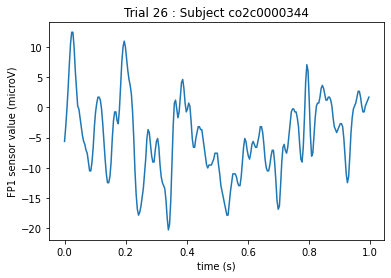

In [ ]:
plt.plot(t,y1)                                  # Time series plot for the control group subject
plt.title('Trial 26 : Subject co2c0000344')     # Formatting the plot
plt.xlabel('time (s)')
plt.ylabel('FP1 sensor value (microV)')
plt.show()

In [ ]:
y2 = train[train.sensor_position == 'FP1'][train.name == 'co2a0000365'][train.trial_number == 26].sensor_value  # FP1 sensor value for an alcoholic subject

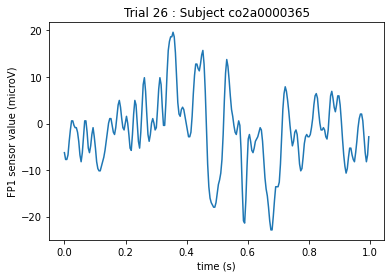

In [ ]:
plt.plot(t,y2)                                  # Time series plot for the alcoholic subject
plt.title('Trial 26 : Subject co2a0000365')     # Formatting the plot
plt.xlabel('time (s)')
plt.ylabel('FP1 sensor value (microV)')
plt.show()

The time series appear quite different, which is a good indication for us (after all, we are trying to see the effect of alcohol on response to stimulus; no difference might mean that there is no effect, though the presence of a difference does not necessarily mean that there is an effect)

From now on, we will use channel numbers rather than sensor names, as the numerical data is easier to deal with and plot.

In [ ]:
train.channel.unique().shape  # Number of unique channels

(61,)

In [ ]:
train.channel.unique()   # List of unique channels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

In [ ]:
train.time.unique()    # List of time steps

array([0.        , 0.00390625, 0.0078125 , 0.01171875, 0.015625  ,
       0.01953125, 0.0234375 , 0.02734375, 0.03125   , 0.03515625,
       0.0390625 , 0.04296875, 0.046875  , 0.05078125, 0.0546875 ,
       0.05859375, 0.0625    , 0.06640625, 0.0703125 , 0.07421875,
       0.078125  , 0.08203125, 0.0859375 , 0.08984375, 0.09375   ,
       0.09765625, 0.1015625 , 0.10546875, 0.109375  , 0.11328125,
       0.1171875 , 0.12109375, 0.125     , 0.12890625, 0.1328125 ,
       0.13671875, 0.140625  , 0.14453125, 0.1484375 , 0.15234375,
       0.15625   , 0.16015625, 0.1640625 , 0.16796875, 0.171875  ,
       0.17578125, 0.1796875 , 0.18359375, 0.1875    , 0.19140625,
       0.1953125 , 0.19921875, 0.203125  , 0.20703125, 0.2109375 ,
       0.21484375, 0.21875   , 0.22265625, 0.2265625 , 0.23046875,
       0.234375  , 0.23828125, 0.2421875 , 0.24609375, 0.25      ,
       0.25390625, 0.2578125 , 0.26171875, 0.265625  , 0.26953125,
       0.2734375 , 0.27734375, 0.28125   , 0.28515625, 0.28906

In [ ]:
train.time.unique().shape  # Number of samples

(256,)

<hr style="height:1px;border-width:0;color:black;background-color:black"><br><br>

## Data to Image

We assign the subject names to variables, so that we can easily repeat the process for a different set of subjects.

In [ ]:
nameC = 'co2c0000344'          # Conrol group subject     
nameA = 'co2a0000365'          # Alcoholic subject

We filter the dataset to contain only entries pertaining to the selected subject. This reduces the dataset size and helps in faster processing.

In [ ]:
personC = train[train.name == nameC]    
personA = train[train.name == nameA]     

In [ ]:
personA.shape  # Checking number of entries corresponding to personA

(468480, 9)

After filtering, the number of entries are reduced to 4,68,480 from 70,42,816, which is an order of magnitude smaller.

__Defining Functions__

Now, we define functions to encode our time series data for different channels as an image.

The `index_encode` function encodes the channel number as an index number for the image matrix.

In [ ]:
def index_encode(channel):
  if channel < 31:   
    y = channel
  else:                     # Channel 31 is missing, so for channel number greater than 31, we subtract 1
    y = channel - 1
 # print("x", x, "y", y)
  return (y)


The function `average_matching` inputs the dataset, name, and matching condition, and outputs a matrix with its row-indices as the time values and its column-indices as the channel values. The matrix entries are the sensor values corresponding to that channel and time, averaged over all trials pertaining to the person and matching condition.

While this would be a better implementation in principle than what we subsequently do, but this function takes a lot of time to execute (about an year, as a rough estimate), and is hence not used.

In [ ]:
def average_matching(df, name, condition):
    trial_list = df[df.matching_condition == condition].trial_number.unique()                                 # Selecting the appropriate trialsmparison of EEG s
    avg = np.zeros((train.time.unique().shape[0], train.channel.unique().shape[0]))                           # Creating an array with dimensions as time-steps x channels
    for trial in trial_list:
      for channel in train.channel.unique():
        y = int(index_encode(channel))
        for time in train.time.unique():
          x = int(time*256)                                                                                   # Encoding time-step number as index number
          avg[x][y] += df[df.trial_number == trial][df.channel == channel][df.time == time].sensor_value       # Assigning sensor value to the corresponding matrix entry 
    avg /= trial_list.shape[0]                                                                                  # Taking the mean      
    return avg 

The function `to_grid` serves the same purpose as `average_matching`, but it uses sensor values from only one trial rather than taking an average over all the trials pertaining to that person and matching condition. 

This does not make optimal use of the large amout of data available, but it does execute relatively faster. 

In [ ]:
def to_grid(df, name, condition):
    trial = df[df.matching_condition == condition].trial_number.unique()[0]                                   # Selecting an appropriate trial
    z = np.zeros((train.time.unique().shape[0], train.channel.unique().shape[0]))                             # Creating an array with dimensions as time-steps x channels
    for channel in train.channel.unique():
      y = int(index_encode(channel))
      for time in train.time.unique():                                                                        # Encoding time-step number as index number
        x = int(time*256)                                                                                     # Assigning sensor value to the corresponding matrix entry
        z[x][y] = df[df.trial_number == trial][df.channel == channel][df.time == time].sensor_value  
    return z

We create lists containing the time and channel values (which are the same for all the experiments) for future use.

In [ ]:
time = train[train.name == nameA][train.trial_number == 26].time
channel = train[train.name == nameA][train.trial_number == 26].channel

__Encoding to Image and Plotting__

We use the `to_grid` function created above to encode data for persons `nameA` and `nameC` for the three matching conditions. <br>

(Do not re-run. Takes time)

In [ ]:
z11 = to_grid(personC, nameC, 'S1 obj')

In [ ]:
z12 = to_grid(personA, nameA, 'S1 obj')

In [ ]:
z21 = to_grid(personC, nameC, 'S2 match')

In [ ]:
z22 = to_grid(personA, nameA, 'S2 match')

In [ ]:
z31 = to_grid(personC, nameC, 'S2 nomatch')

In [ ]:
z32 = to_grid(personA, nameA, 'S2 nomatch')

Finally, we plot the images obtained.

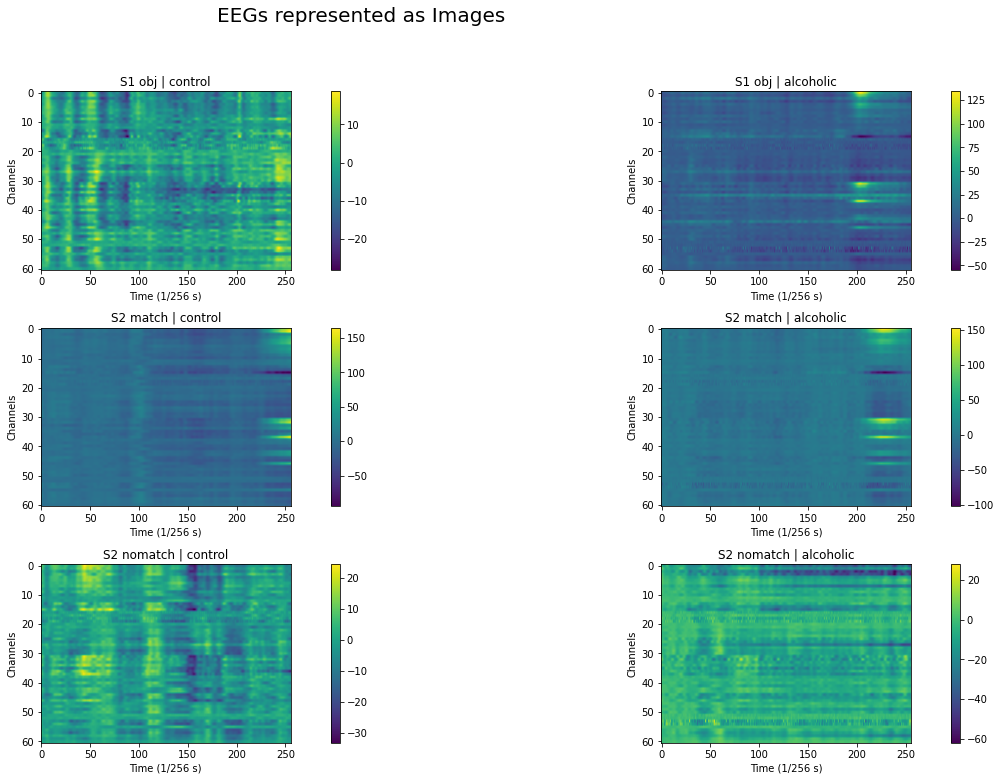

In [ ]:
#fig = plt.figure(figsize=(20,10))

#ax = fig.add_subplot(3, 2, 1, projection = '3d')
#ax.imshow(z11, cmap = 'viridis')

#ax = fig.add_subplot(3, 2, 1, projection = '3d')
#ax.imshow(z12, cmap = 'inferno')

#ax = fig.add_subplot(3, 2, 1, projection = '3d')
#ax.imshow(z21, cmap = 'viridis')

#ax = fig.add_subplot(3, 2, 1, projection = '3d')
#ax.imshow(z22, cmap = 'inferno')

#ax = fig.add_subplot(3, 2, 1, projection = '3d')
#ax.imshow(z31, cmap = 'viridis')

#ax = fig.add_subplot(3, 2, 1, projection = '3d')
#ax.imshow(z32, cmap = 'inferno')

#plt.show()
fig, axs = plt.subplots(3, 2, figsize=(20,10))
fig.suptitle('EEGs represented as Images', fontsize=20, y=1.08) 

ax11 = axs[0, 0]
img11 = ax11.imshow(np.transpose(z11), aspect=3/1)
ax11.set_title('S1 obj | control', fontsize=12)
fig.colorbar(img11, ax=ax11)

ax12 = axs[0, 1]
img12 = ax12.imshow(np.transpose(z12), aspect=3/1)
ax12.set_title('S1 obj | alcoholic', fontsize=12)
fig.colorbar(img12, ax=ax12)

ax21 = axs[1, 0]
img21 = ax21.imshow(np.transpose(z21), aspect=3/1)
ax21.set_title('S2 match | control', fontsize=12)
fig.colorbar(img21, ax=ax21)

ax22 = axs[1, 1]
img22 = ax22.imshow(np.transpose(z22), aspect=3/1)
ax22.set_title('S2 match | alcoholic', fontsize=12)
fig.colorbar(img22, ax=ax22)

ax31 = axs[2, 0]
img31 = ax31.imshow(np.transpose(z31), aspect=3/1)
ax31.set_title('S2 nomatch | control', fontsize=12)
fig.colorbar(img31, ax=ax31)

ax32 = axs[2, 1]
img32 = ax32.imshow(np.transpose(z32), aspect=3/1)
ax32.set_title('S2 nomatch | alcoholic', fontsize=12)
fig.colorbar(img32, ax=ax32)

for ax in axs.flat:
   ax.set(xlabel='Time (1/256 s)', ylabel='Channels')

plt.tight_layout()

#Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

<hr style="height:1px;border-width:0;color:black;background-color:black"><br><br>

## Noise Reduction

Here, we create functions for bandpass and notch filtering of the frequencies. The bandpass filter eliminates frequencies lesser than $0.5 Hz$ and greater than $75 Hz$. These frequencies include power line interference, electromyography artifacts, electrodermal artifacts, and electrooculography artifacts<sup><a href = "https://ieeexplore.ieee.org/document/7311222">[3]</a></sup>. The notch filter eliminates the $60 Hz$ frequency component, which is the frequency of power line voltage in the USA (The University from which this data is taken is in the USA).



__Defining Functions__

At first, we create a function `bandpass1d` that applies a bandpass as well as a notch filter on a 1-dimensional time series.

In [ ]:
def bandpass1d(z):
    mask = np.ones(256)                      # The mask which is used to select frequencies
    mask[:53] = 0                            # Bandpass filtering          
    mask[204:] = 0
    mask[128] = 0
    mask[188] = 0                            # Notch filtering
    mask[68]  = 0

    f = z.copy()                             # Create a copy of z so that the original remains the same
    
    f1 = np.ones(256)                        # Defining variables
    fshift = np.ones(256)
    new_fshift = np.ones(256)
    f_ishift = np.ones(256)
    f_new = np.ones(256)
   
    f1 = np.fft.fft(f)                       # Taking fft of the signal      

    fshift = np.fft.fftshift(f1)             # Rearranging the frequencies
    
    new_fshift = fshift * mask               # Filtering the frequencies based on mask
    
    f_ishift = np.fft.ifftshift(new_fshift)  # Reverting back the filtering
    
    f = np.fft.ifft(f_ishift)                # Inverse fourier transform


################################################################################
    
    ## Debugging Purposes
    
    #print(f1[:,i] - f_ishift[:,i])
#    plt.figure()
#    plt.plot(freq,f1)                                  # Time series plot for the control group subject
#    plt.title('Before')     # Formatting the plot
#    plt.xlabel('Freq')
#    plt.ylabel('FP1 sensor value')
#    plt.show()

#    plt.figure()
#    plt.plot(freq,f_ishift)                                  # Time series plot for the control group subject
#    plt.title('After')     # Formatting the plot
#    plt.xlabel('Freq')
#    plt.ylabel('FP1 sensor value')
#    plt.show()

#    plt.figure()
#    plt.plot(t,z)                                  # Time series plot for the control group subject
#    plt.title('Time Before')     # Formatting the plot
#    plt.xlabel('Time')
#    plt.ylabel('FP1 sensor value')
#    plt.show()
    
#    plt.figure()
#    plt.plot(t,f)                                  # Time series plot for the control group subject
#    plt.title('Time After')     # Formatting the plot
#    plt.xlabel('Time')
#    plt.ylabel('FP1 sensor value')
#    plt.show()
################################################################################    
    
    return f        

Now, we define another function `bandpass` that applies `bandpass1d` to each column (channel) of the matrix. This way, we apply the frequency filters to the time series of each channel. 

In [ ]:
def bandpass(z):


################################################################################
  ## Debugging Purposes  

#  mask = np.ones(256)
#  mask[:126] = 0
#  mask[131:] = 0

  #mask[:53] = 0
  #mask[204:] = 0
  #mask[128] = 0
################################################################################


  deltat = 0.00390625
  freq = np.fft.fftfreq(256, deltat)
  f = z.copy()                         # keeping input intact
  outf = z.copy()                      # for same dimensions as z
  
  for i in range(f.shape[1]):

    comp1d = bandpass1d(f[:,i])
    outf[:,i] = comp1d



################################################################################
      ## Debugging Purposes

#    f1 = np.ones((256,61))
#    fshift = np.ones((256,61))
#    new_fshift = np.ones((256,61))
#    f_ishift = np.ones((256,61))
 #  f_new = np.ones((256,61))
   
#    f1[:,i] = np.fft.fft(f[:,i])      #along the columns
#    fshift[:,i] = np.fft.fftshift(f1[:,i])
#    new_fshift[:,i] = fshift[:,i] * mask
#    f_ishift[:,i] = np.fft.ifftshift(new_fshift[:,i])
#    f[:,i] = np.fft.ifft(f_ishift[:,i])

    #print(f1[:,i] - f_ishift[:,i])
#    plt.figure()
#    plt.plot(freq,f1[:,i])                                  # Time series plot for the control group subject
#    plt.title('Before')     # Formatting the plot
#    plt.xlabel('Freq')
#    plt.ylabel('FP1 sensor value')
#    plt.show()

#    plt.figure()
#    plt.plot(freq,outf[:,i])                                  # Time series plot for the control group subject
#    plt.title('After')     # Formatting the plot
#    plt.xlabel('Freq')
#    plt.ylabel('FP1 sensor value')
#    plt.show()

#    plt.figure()
#    plt.plot(t,z[:,i])                                  # Time series plot for the control group subject
#    plt.title('Time Before')     # Formatting the plot
#    plt.xlabel('Time')
#    plt.ylabel('FP1 sensor value')
#    plt.show()
    
#    plt.figure()
#    plt.plot(t,outf[:,i])                                  # Time series plot for the control group subject
#    plt.title('Time After')     # Formatting the plot
#    plt.xlabel('Time')
#    plt.ylabel('FP1 sensor value')
#    plt.show()
################################################################################


  return outf

__Filtering and Plotting__

We use the `bandpass` function created above to filter the image-encoded-data `z11`, `z12`, `z21`, `z22`, `z31`, `z32`. <br>

In [ ]:
filtered11 = bandpass(z11)
filtered12 = bandpass(z12)
filtered21 = bandpass(z21)
filtered22 = bandpass(z22)
filtered31 = bandpass(z31)
filtered32 = bandpass(z32)

Finally, we plot the filtered images obtained.

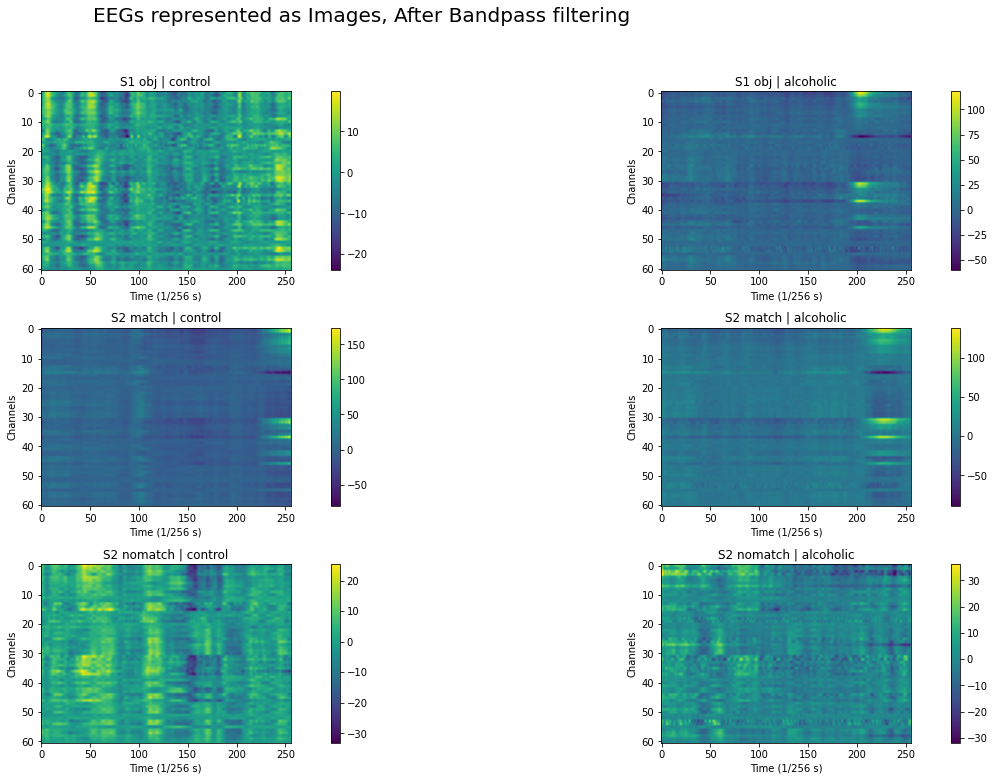

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(20,10))
fig.suptitle('EEGs represented as Images, After Bandpass filtering', fontsize=20, y=1.08) 

ax11 = axs[0, 0]
img11 = ax11.imshow(np.transpose(filtered11), aspect=3/1)
ax11.set_title('S1 obj | control', fontsize=12)
fig.colorbar(img11, ax=ax11)

ax12 = axs[0, 1]
img12 = ax12.imshow(np.transpose(filtered12), aspect=3/1)
ax12.set_title('S1 obj | alcoholic', fontsize=12)
fig.colorbar(img12, ax=ax12)

ax21 = axs[1, 0]
img21 = ax21.imshow(np.transpose(filtered21), aspect=3/1)
ax21.set_title('S2 match | control', fontsize=12)
fig.colorbar(img21, ax=ax21)

ax22 = axs[1, 1]
img22 = ax22.imshow(np.transpose(filtered22), aspect=3/1)
ax22.set_title('S2 match | alcoholic', fontsize=12)
fig.colorbar(img22, ax=ax22)

ax31 = axs[2, 0]
img31 = ax31.imshow(np.transpose(filtered31), aspect=3/1)
ax31.set_title('S2 nomatch | control', fontsize=12)
fig.colorbar(img31, ax=ax31)

ax32 = axs[2, 1]
img32 = ax32.imshow(np.transpose(filtered32), aspect=3/1)
ax32.set_title('S2 nomatch | alcoholic', fontsize=12)
fig.colorbar(img32, ax=ax32)

for ax in axs.flat:
   ax.set(xlabel='Time (1/256 s)', ylabel='Channels')
  
plt.tight_layout()

#Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

__Verification__

Verifying that the filter indeed works by plotting the time series for a sensor before and after filtering, and the difference between the two (Since the filtered images look quite the same as the original ones)

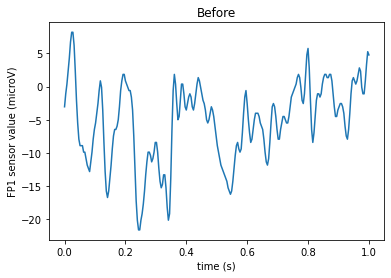

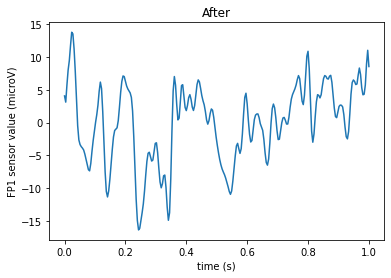

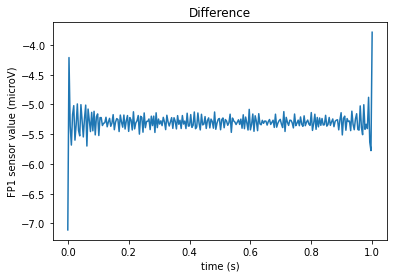

In [ ]:
t = np.linspace(0,1,256)          # time axis for a control group subject 
y1 = z11[:,2]           # FP1 sensor value for a control group subject
y2 = filtered11[:,2]

plt.figure(1)
plt.plot(t,y1)                                  # Time series plot for the control group subject
plt.title('Before')     # Formatting the plot
plt.xlabel('time (s)')
plt.ylabel('FP1 sensor value (microV)')
plt.show()

plt.figure(2)
plt.plot(t,y2)                                  # Time series plot for the control group subject
plt.title('After')     # Formatting the plot
plt.xlabel('time (s)')
plt.ylabel('FP1 sensor value (microV)')
plt.show()

plt.figure(3)
plt.plot(t,y1-y2)                                  # Time series plot for the control group subject
plt.title('Difference')     # Formatting the plot
plt.xlabel('time (s)')
plt.ylabel('FP1 sensor value (microV)')
plt.show()

<hr style="height:1px;border-width:0;color:black;background-color:black"><br><br>

## Band-wise Analysis

__About The Bands__


$ \delta : 0.5Hz - 4Hz$ <br><br>
$ \theta : 4Hz - 8Hz$ <br><br>
$ \alpha : 8Hz - 13Hz$ <br><br>
$ \beta : 13Hz - 32Hz$ <br><br>
$ \gamma : 32Hz - 100Hz$ (Only considered till 75Hz due to application Bandpass Filter) <br><br>

<img src="https://choosemuse.com/app/uploads/2018/10/storage.googleapis.com-486681944373284.jpg" alt="sensors-used" border="0"><br><br>

__Plotting the Power Spectral Density__

We Plot the PSD of one of the time series before and after the Filtering.

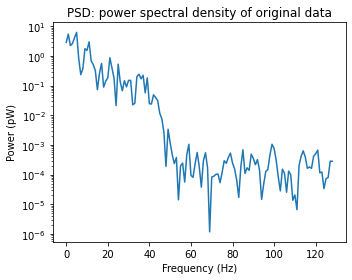

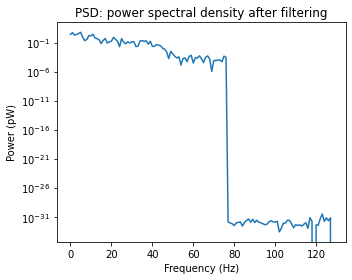

In [ ]:
import scipy
from scipy import *
from scipy.signal import chirp

freqs2, psd2 = scipy.signal.welch(z11[:,0], 256)  # Inbuilt function to get values for plotting PSD of original data

plt.figure(figsize=(5, 4))
plt.semilogy(freqs2, psd2)
plt.title('PSD: power spectral density of original data')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (pW)')
plt.tight_layout()
plt.show()


freqs1, psd1 = scipy.signal.welch(filtered11[:,0], 256)  # Inbuilt function to get values for plotting PSD of filtered data

plt.figure(figsize=(5, 4))
plt.semilogy(freqs1, psd1)
plt.title('PSD: power spectral density after filtering')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (pW)')
plt.tight_layout()
plt.show()



We define a function to calculate the average power in the &alpha;, &beta;, &gamma;, &delta;, and &theta; frequency bands. 

In [ ]:
def average_power_1d(psd):
  arr = np.zeros(5)        # Array for storing average power across various bands
  sum_delta = 0  
  sum_theta = 0
  sum_alpha = 0
  sum_beta = 0
  sum_gamma = 0
  for d in range(1,4):
      sum_delta += psd[d]
  arr[0] = sum_delta/2     # Average power in delta band
  for t in range(4,8):
      sum_theta += psd[t]
  arr[1] = sum_theta/3     # Average power in theta band
  for a in range(8,13):
      sum_alpha += psd[a]
  arr[2] = sum_alpha/4     # Average power in alpha band
  for b in range(13,32):
      sum_beta += psd[b]   
  arr[3] = sum_beta/18     # Average power in beta band
  for g in range(32,76):
      sum_gamma += psd[g] 
  arr[4] = sum_gamma/44    # Average power in gamma band
  return arr

def average_power(z):
  f = z.copy()                    # Making copy of original data
  out_power = np.zeros((5,61))    # Array for storing average power across various bands for all channels
  for i in range(f.shape[1]):
     freqs, psd = scipy.signal.welch(f[:,i], 256)
     out_power[:,i] = average_power_1d(psd)
  return out_power



We use the function defined above to calculate the average power in frequency bands for the filtered data.

In [ ]:
power11 = average_power(filtered11)
power12 = average_power(filtered12)
power21 = average_power(filtered21)
power22 = average_power(filtered22)
power31 = average_power(filtered31)
power32 = average_power(filtered32)

Plotting the results.

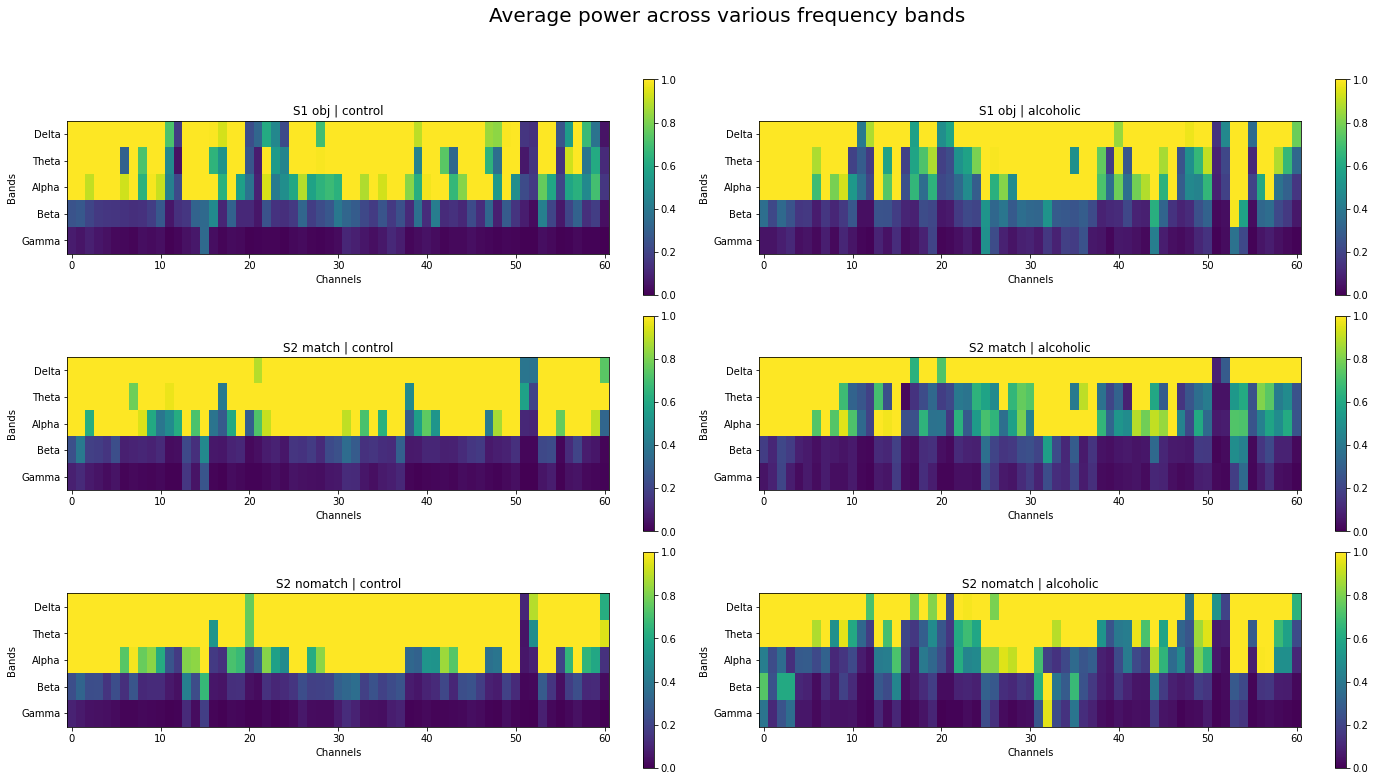

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(20,10))
fig.suptitle('Average power across various frequency bands', fontsize=20, y=1.08) 

ax11 = axs[0, 0]
img11 = ax11.imshow(power11, aspect=3/1, vmin=0, vmax=1)
ax11.set_title('S1 obj | control', fontsize=12)
fig.colorbar(img11, ax=ax11)

ax12 = axs[0, 1]
img12 = ax12.imshow(power12, aspect=3/1, vmin=0, vmax=1)
ax12.set_title('S1 obj | alcoholic', fontsize=12)
fig.colorbar(img12, ax=ax12)

ax21 = axs[1, 0]
img21 = ax21.imshow(power21, aspect=3/1, vmin=0, vmax=1)
ax21.set_title('S2 match | control', fontsize=12)
fig.colorbar(img21, ax=ax21)

ax22 = axs[1, 1]
img22 = ax22.imshow(power22, aspect=3/1, vmin=0, vmax=1)
ax22.set_title('S2 match | alcoholic', fontsize=12)
fig.colorbar(img22, ax=ax22)

ax31 = axs[2, 0]
img31 = ax31.imshow(power31, aspect=3/1, vmin=0, vmax=1)
ax31.set_title('S2 nomatch | control', fontsize=12)
fig.colorbar(img31, ax=ax31)

ax32 = axs[2, 1]
img32 = ax32.imshow(power32, aspect=3/1, vmin=0, vmax=1)
ax32.set_title('S2 nomatch | alcoholic', fontsize=12)
fig.colorbar(img32, ax=ax32)

for ax in axs.flat:
   ax.set(xlabel='Channels', ylabel='Bands')
   ax.set_yticklabels(['','Delta','Theta','Alpha','Beta','Gamma'])


plt.tight_layout()

<hr style="height:1px;border-width:0;color:black;background-color:black"><br><br>

## Conclusion

The same process was tried on some different sets of persons, and the following plots were obtained:

<img src="https://i.ibb.co/D9qhnN5/index.png" border="0"><br><br>

<img src="https://i.ibb.co/wKnQt3F/download.png" border="0"><br><br>

<br><br>

From the above plots, we can conclude that while non-alcoholics have significant activity in the &delta; and &theta; frequency bands (even in the &alpha; band for some subjects), alcoholics have significant activity only in the &delta; band, with the activity in the other bands relatively lesser by a significant amount. 

As the &delta; band is the only significant band in alcoholics' EEG data, and since it is associated with deep sleep and loss of bodily awareness, we can roughly say that alcholics have a general lack of awareness.

As compared to the alcoholics, the control group subjects show significant activity in the &theta; and &alpha; bands. We can say that the control group subjects are more mindful and relaxed in general. Still, the significant amount of power in the &delta; band for the control group could not be explained satisfactorily.


<hr style="height:1px;border-width:0;color:black;background-color:black"><hr style="height:1px;border-width:0;color:black;background-color:black"><br>

## Thank You!!

<p>References: <br> 

&emsp; [1] https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.294.1979&rep=rep1&type=pdf, page 197 <br> 

&emsp; [2] https://archive.ics.uci.edu/ml/datasets/eeg+database <br> 

&emsp; [3] https://ieeexplore.ieee.org/document/7311222 <br>

